# LoRA editing with SAE latent

In [ ]:
path = "weights2weights/weights_datasets"
device = "cuda"

In [2]:
import os
from copy import deepcopy

import torch
import numpy as np
import pandas as pd

from safetensors.torch import load_file


### Check activations
In order to see which dimensions in latent space could be responsible for hair color: 
1. Get sample of blondes and sample of blacks - DONE
2. Save separate datasets - DONE
3. Pass through sae
4. Get histogram of latent features (sorted)
5. Choose high for blondes but low for blacks
6. Edit those 


In [3]:
blondes = torch.load(f"{path}/blondes.pt")
brunettes = torch.load(f"{path}/brunettes.pt")

In [4]:
from sae import Sae
sae_path = "runs/test1/0"
sae = Sae.load_from_disk(sae_path,device=device)

Triton not installed, using eager implementation of SAE decoder.


In [5]:
sae.eval()

blon_acts, brun_acts = [], []
for blon, brun in zip(blondes, brunettes):
    blon_acts.append(sae.pre_acts(blon.to(device)))
    brun_acts.append(sae.pre_acts(brun.to(device)))
    

In [6]:
blon_acts[0].ne(0).sum()

tensor(62, device='cuda:0')

<BarContainer object of 1000 artists>

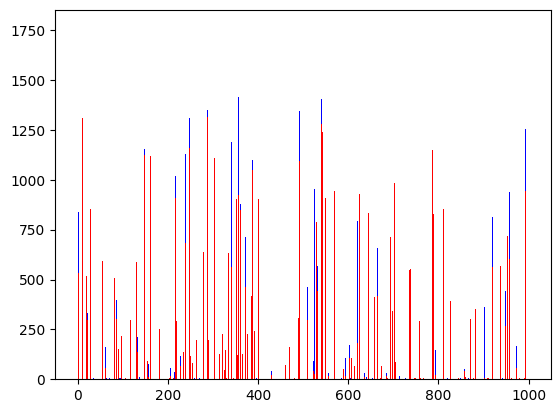

In [7]:
import matplotlib.pyplot as plt

plt.bar(range(1000), torch.stack(blon_acts).ne(0).sum(dim=0).cpu().numpy(), color='blue')
plt.bar(range(1000), torch.stack(brun_acts).ne(0).sum(dim=0).cpu().numpy(), color='red')

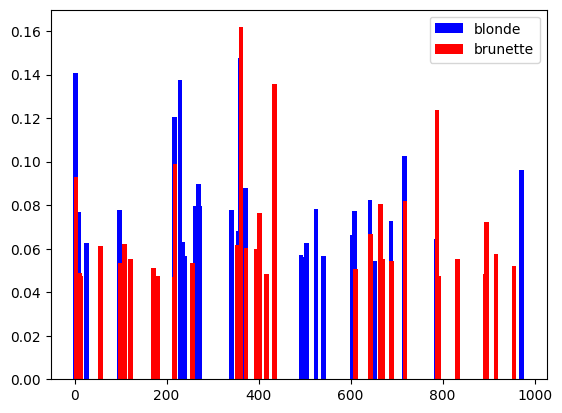

In [8]:
blonk = torch.stack(blon_acts).mean(dim=0).topk(32)
brunk = torch.stack(brun_acts).mean(dim=0).topk(32)
plt.bar(blonk.indices.cpu().detach().numpy(), blonk.values.cpu().detach().numpy(), width=10, color='blue', label="blonde")
plt.bar(brunk.indices.cpu().detach().numpy()+1, brunk.values.cpu().detach().numpy(), width=10, color='red', label="brunette")
plt.legend()
plt.show()

In [175]:
sorted(brunk.indices.cpu().detach().numpy())

[2,
 11,
 12,
 55,
 98,
 107,
 121,
 170,
 179,
 216,
 217,
 256,
 352,
 361,
 372,
 395,
 401,
 416,
 434,
 610,
 642,
 664,
 669,
 688,
 717,
 787,
 791,
 832,
 892,
 895,
 915,
 954]

In [70]:
sorted(blonk.indices.cpu().detach().numpy())

[2,
 8,
 26,
 98,
 216,
 217,
 229,
 236,
 239,
 263,
 269,
 271,
 341,
 357,
 361,
 372,
 434,
 492,
 502,
 504,
 525,
 541,
 604,
 608,
 642,
 653,
 664,
 688,
 717,
 787,
 895,
 972]

test 229

In [61]:
e = sae.encode(blondes[0])
e

EncoderOutput(top_acts=tensor([0.3838, 0.1046, 0.0895, 0.1207, 0.1849, 0.1681, 0.1052, 0.1236, 0.5314,
        0.2447, 0.0602, 0.0599, 0.0814, 0.0694, 0.0835, 0.1886, 0.1018, 0.1813,
        0.0961, 0.1520, 0.0862, 0.2751, 0.1207, 0.0988, 0.1092, 0.0650, 0.0655,
        0.1426, 0.1671, 0.1448, 0.0893, 0.0562], device='cuda:0',
       grad_fn=<TopkBackward0>), top_indices=tensor([  8,  26,  52,  74, 229, 239, 271, 357, 361, 384, 486, 504, 513, 525,
        542, 568, 613, 640, 649, 664, 688, 717, 732, 741, 746, 787, 864, 902,
        943, 949, 966, 953], device='cuda:0'))

In [8]:
sae.decode(e.top_acts, e.top_indices)

tensor([-0.0334,  0.0082,  0.0261,  ..., -0.0062,  0.0043,  0.0008],
       device='cuda:0', grad_fn=<AddBackward0>)

In [9]:
sae(blondes[0]).sae_out

tensor([-0.0334,  0.0082,  0.0261,  ..., -0.0062,  0.0043,  0.0008],
       device='cuda:0', grad_fn=<AddBackward0>)

In [22]:
e.top_acts[4]=0.5
e

EncoderOutput(top_acts=tensor([0.3838, 0.1046, 0.0895, 0.1207, 0.5000, 0.1681, 0.1052, 0.1236, 0.5314,
        0.2447, 0.0602, 0.0599, 0.0814, 0.0694, 0.0835, 0.1886, 0.1018, 0.1813,
        0.0961, 0.1520, 0.0862, 0.2751, 0.1207, 0.0988, 0.1092, 0.0650, 0.0655,
        0.1426, 0.1671, 0.1448, 0.0893, 0.0562], device='cuda:0',
       grad_fn=<CopySlices>), top_indices=tensor([  8,  26,  52,  74, 229, 239, 271, 357, 361, 384, 486, 504, 513, 525,
        542, 568, 613, 640, 649, 664, 688, 717, 732, 741, 746, 787, 864, 902,
        943, 949, 966, 953], device='cuda:0'))

## Original

In [12]:
model_path = os.path.join(os.getcwd(), "base_model")

In [13]:
# Get weights dictionary
base_weights = load_file( f"{model_path}/unet/adapter_model.safetensors")

In [14]:
from diffusers import DiffusionPipeline 
from peft import PeftModel
from peft.utils.save_and_load import load_peft_weights

In [15]:
adapters_weights1 = deepcopy(base_weights)
start_idx = 0

for key in base_weights.keys():
    shape = base_weights[key].shape
    end_idx = start_idx + torch.prod(torch.tensor(shape)).item()  # Calculate end index
    adapters_weights1[key] = blondes[0][start_idx:end_idx].reshape(*shape)
    start_idx = end_idx

In [16]:
pipe = DiffusionPipeline.from_pretrained("stablediffusionapi/realistic-vision-v51", 
                                         torch_dtype=torch.float16,safety_checker = None,
                                         requires_safety_checker = False).to(device)
   
pipe.unet = PeftModel.from_pretrained(pipe.unet, f"{model_path}/unet", adapter_name="identity1")
# adapters_weights1 = load_peft_weights(f"{model_path}/unet", device="cuda:0")
pipe.unet.load_state_dict(adapters_weights1, strict = False)
pipe.to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/net/tscratch/people/plgkingak/w2w/lib/python3.12/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.28.0",
  "_name_or_path": "stablediffusionapi/realistic-vision-v51",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

/net/tscratch/people/plgkingak/w2w/lib/python3.12/site-packages/peft/tuners/lora/model.py:364: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  return getattr(self.model, name)


  0%|          | 0/50 [00:00<?, ?it/s]

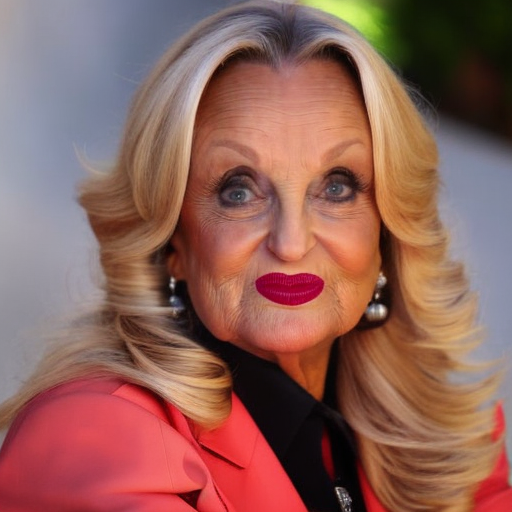

In [17]:
generator = torch.Generator(device=device)
generator = generator.manual_seed(5)
latents = torch.randn(
        (1, pipe.unet.in_channels, 512 // 8, 512 // 8),
        generator = generator,
        device = device
    ).half()

#inference parameters
prompt = "sks person" #"sks person in a hat in a forest"
negative_prompt = "low quality, blurry, unfinished"
guidance_scale = 3.0
ddim_steps = 50
#run inference
image = pipe(prompt, num_inference_steps=ddim_steps, guidance_scale=guidance_scale,  negative_prompt=negative_prompt, latents = latents ).images[0]
image

## Edited

In [9]:
e = sae.encode(blondes[0])
e

EncoderOutput(top_acts=tensor([0.3838, 0.1046, 0.0895, 0.1207, 0.1849, 0.1681, 0.1052, 0.1236, 0.5314,
        0.2447, 0.0602, 0.0599, 0.0814, 0.0694, 0.0835, 0.1886, 0.1018, 0.1813,
        0.0961, 0.1520, 0.0862, 0.2751, 0.1207, 0.0988, 0.1092, 0.0650, 0.0655,
        0.1426, 0.1671, 0.1448, 0.0893, 0.0562], device='cuda:0',
       grad_fn=<TopkBackward0>), top_indices=tensor([  8,  26,  52,  74, 229, 239, 271, 357, 361, 384, 486, 504, 513, 525,
        542, 568, 613, 640, 649, 664, 688, 717, 732, 741, 746, 787, 864, 902,
        943, 949, 966, 953], device='cuda:0'))

In [ ]:
# e.top_acts[4]=0.5 ## 229
# e.top_acts[6]=-2 ## 271
e.top_acts[-1]=1
e

EncoderOutput(top_acts=tensor([0.3838, 0.1046, 0.0895, 0.1207, 0.1849, 0.1681, 0.1052, 0.1236, 0.5314,
        0.2447, 0.0602, 0.0599, 0.0814, 0.0694, 0.0835, 0.1886, 0.1018, 0.1813,
        0.0961, 0.1520, 0.0862, 0.2751, 0.1207, 0.0988, 0.1092, 0.0650, 0.0655,
        0.1426, 0.1671, 0.1448, 0.0893, 1.0000], device='cuda:0',
       grad_fn=<CopySlices>), top_indices=tensor([  8,  26,  52,  74, 229, 239, 271, 357, 361, 384, 486, 504, 513, 525,
        542, 568, 613, 640, 649, 664, 688, 717, 732, 741, 746, 787, 864, 902,
        943, 949, 966, 953], device='cuda:0'))

In [10]:
from sae.sae import EncoderOutput
e2 = EncoderOutput(top_acts=torch.cat((e.top_acts,torch.tensor([-1]).to(device)), 0),
                   top_indices=torch.cat((e.top_indices,torch.tensor([434]).to(device)), 0))

In [189]:
edited = sae.decode(e2.top_acts, e2.top_indices)

In [190]:
weights_out = edited

In [191]:
new_weights = deepcopy(base_weights)
start_idx = 0

for key in base_weights.keys():
    shape = base_weights[key].shape
    end_idx = start_idx + torch.prod(torch.tensor(shape)).item()  # Calculate end index
    new_weights[key] = weights_out[start_idx:end_idx].reshape(*shape)
    start_idx = end_idx

In [192]:
pipe.unet.load_state_dict(new_weights, strict = False)
pipe.to(device)


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.28.0",
  "_name_or_path": "stablediffusionapi/realistic-vision-v51",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/50 [00:00<?, ?it/s]

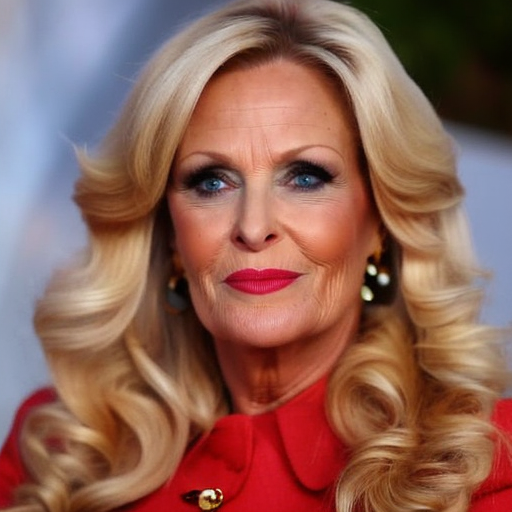

In [193]:
image1 = pipe(prompt, num_inference_steps=ddim_steps, guidance_scale=guidance_scale,  negative_prompt=negative_prompt, latents = latents ).images[0]
image1

## Check all features

0 0


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1 2


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2 4


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

3 6


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

4 8


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

5 10


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

6 12


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

7 14


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

8 16


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

9 18


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

10 20


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

11 22


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

12 24


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

13 26


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

14 28


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

15 30


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

16 32


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

17 34


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

18 36


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

19 38


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

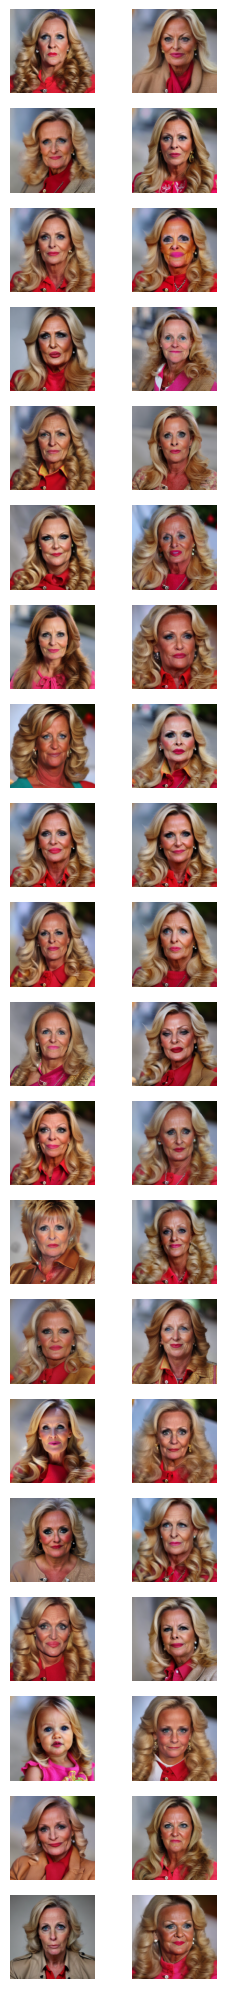

In [22]:
images = []
for i in range(100):
    e = sae.encode(blondes[0])
    print(i, len(images))
    for c in (1, -1):
        if i in e.top_indices:
            e.top_acts[i]=c
            edited = sae.decode(e.top_acts, e.top_indices)
        else:
            e2 = EncoderOutput(top_acts=torch.cat((e.top_acts,torch.tensor([c]).to(device)), 0),
                               top_indices=torch.cat((e.top_indices,torch.tensor([i]).to(device)), 0))
            edited = sae.decode(e2.top_acts, e2.top_indices)
        
        weights_out = edited
        new_weights = deepcopy(base_weights)
        start_idx = 0

        for key in base_weights.keys():
            shape = base_weights[key].shape
            end_idx = start_idx + torch.prod(torch.tensor(shape)).item()  # Calculate end index
            new_weights[key] = weights_out[start_idx:end_idx].reshape(*shape)
            start_idx = end_idx
    
        pipe.unet.load_state_dict(new_weights, strict = False)
        pipe.to(device)
        img = pipe(prompt, num_inference_steps=ddim_steps, guidance_scale=guidance_scale,  negative_prompt=negative_prompt, latents = latents ).images[0]
        images.append(img)
    
    
    if (i+1) % 20 == 0:
        fig, axes = plt.subplots(20, 2, figsize=(3,20))  
        for ax, im in zip(axes.flatten(), images):
            ax.imshow(im)
            ax.axis("off")
        fig.tight_layout()
        fig.show()     
        images = []
        break    


## Input scale

In [7]:
blondes[0].mean()

tensor(-0.0001, device='cuda:0')

In [13]:
blondes.mean(dim=1).mean()

tensor(-8.3644e-05, device='cuda:0')

In [14]:
blondes.mean(dim=1).std()

tensor(3.3231e-05, device='cuda:0')

In [22]:
blondes.std()

tensor(0.0165, device='cuda:0')

In [17]:
import matplotlib.pyplot as plt

(array([5.6460000e+03, 4.6682400e+05, 4.9125050e+06, 1.7885892e+07,
        6.9135627e+07, 8.2050847e+07, 1.8639883e+07, 5.5303960e+06,
        6.5587700e+05, 1.2503000e+04]),
 array([-0.08939227, -0.07166369, -0.05393513, -0.03620655, -0.01847798,
        -0.00074941,  0.01697916,  0.03470773,  0.0524363 ,  0.07016487,
         0.08789344]),
 <BarContainer object of 10 artists>)

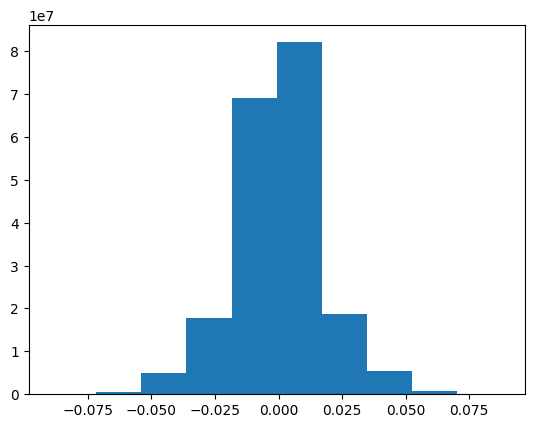

In [19]:
plt.hist(blondes.flatten().cpu().numpy())

(array([5.7510000e+03, 4.4681700e+05, 4.9809260e+06, 1.8330534e+07,
        7.5936116e+07, 7.6318290e+07, 1.7917426e+07, 4.8480720e+06,
        5.0538200e+05, 6.6860000e+03]),
 array([-9.06148106e-02, -7.24975020e-02, -5.43801934e-02, -3.62628885e-02,
        -1.81455798e-02, -2.82712281e-05,  1.80890374e-02,  3.62063460e-02,
         5.43236509e-02,  7.24409595e-02,  9.05582681e-02]),
 <BarContainer object of 10 artists>)

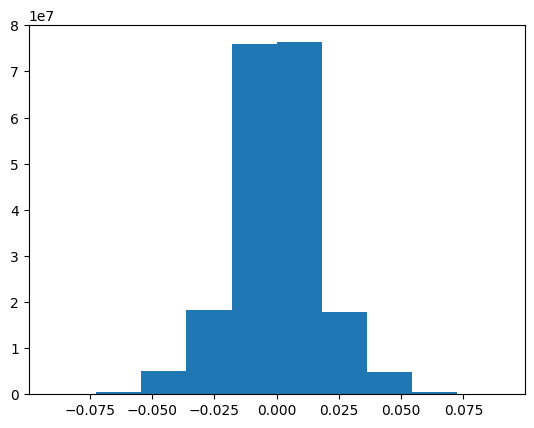

In [23]:
plt.hist(brunettes.flatten().cpu().numpy())